# NYC Schools

# Read in the data

In [1]:
import pandas
import numpy
import re

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Investigate correlations between SAT Scores and survey of parents, teachers, and students

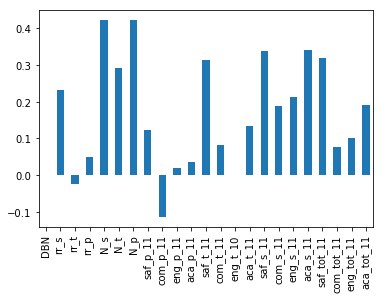

In [10]:
corr_survey = correlations.loc[survey_fields , ]
corr_survey.plot.bar()

plt.show()

The only negative correlation is with "Communication score based on parent responses" meaning that higher SAT score are correlated with a lower communication score from a parent (meaning the school does not communicate with parents?), which is interesting. 

There a lot of modest positive correlations including "Safety and Respect score based on teacher responses" and "Safety and Respect score based on student responses", measuring how safe students and teachers feel at their school. Higher SAT scores are correlated with higher teacher and students responses about feeling safe at school. 

## Investigate SAT scores and school safety

Create scatter plot to more closely examine the relationship between SAT scores and feeling safe at school. 

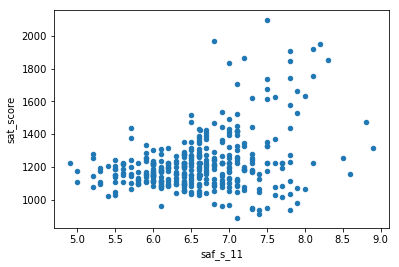

In [11]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

There appears to be a positive relationship. Visualize these on a map to see if there is a location effect. 

/Users/katherine/anaconda2/envs/python3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/katherine/anaconda2/envs/python3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


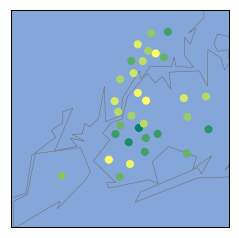

In [16]:
districts = combined.groupby("school_dist").agg(numpy.mean).reset_index()

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder = 2, latlon= True,
         c = districts["saf_s_11"], cmap = "summer")

plt.show()

Manhattan appears to have the highest response of safeness from students. This could be linked to SES, which might be playing a role in feelings of safeness within certain districts/schools/neighborhoods. 

# Racial differences in SAT results

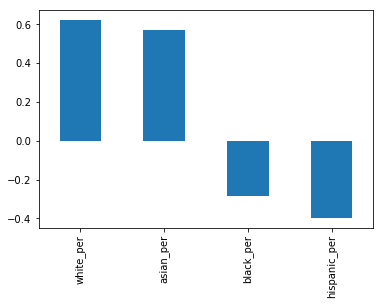

In [24]:
race_per = ["white_per", "asian_per", "black_per", "hispanic_per"]

corr_race_per = correlations.loc[race_per , ]
corr_race_per.plot.bar()

plt.show()

Schools with a higher percentage of Whites or Asians students have higher SAT scores. There is a negative correlation between SAT scores and percentage of Hispanic and Black students (lower SAT scores in schools with a high percentage of Hispanics or Black students). 

## Investigate schools with low SAT scores and high values for percentage of individuals of Hispanic ethnicity 

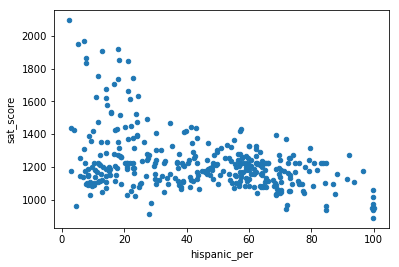

In [36]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

There does appear to be a negative correlation with schools with 100% Hispanic students have low SAT scores. There is however not a strong trend, with the left side of the plot (low percentage of Hispanic students) having a wide range of SAT scores. However, for the high percentage of Hispanic student schools, they do not have such a wide spread resulting in the negative correlation. 

## Investigate Schools with a percentage of individuals of Hispanic ethnicity greater than 95%

In [38]:
highHisp = combined[ (combined['hispanic_per'] > 95)]

print(highHisp["School Name"])

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Google search for these schools reveals that at least one "GREGORIO LUPERON HIGH SCHOOL" is specifically for "newly arrived Spanish-speaking immigrants", again linking English as a second language to schools with a higher percentage of individuals of Hispanic ethnicity.

### Schools with a percentage of individuals of Hispanic ethnicity less than 10% and an average SAT score greater than 1800.

In [39]:
highSAT_lowHisp = combined[ (combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

print(highSAT_lowHisp["School Name"])

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


These all appear to be schools that specialize in "Science & math", and have an entrance exam that needs to be passed to be able to attend (Specialized High Schools Admissions Test). 

# Gender difference in SAT results

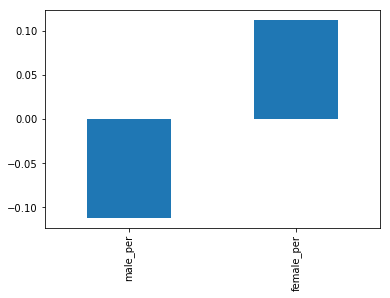

In [40]:
sex_per = ["male_per", "female_per"]

corr_sex_per = correlations.loc[sex_per , ]
corr_sex_per.plot.bar()

plt.show()

Schools with a higher percentage of females have higher SAT scores. Those with a higher percentage of males have lower SAT scores. This suggests that females may do better on the SATs than males.

## Schools with high SAT scores and a high percentage of females

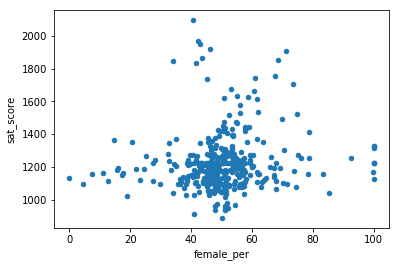

In [42]:
combined.plot.scatter(x="female_per", y="sat_score")

This plot is a little messy, with most data points between 40% and 60% female. There are high SAT values (the highest) for around 40% female.

## Schools with a percentage of females greater than 60% and an average SAT score greater than 1700.

In [43]:
highSAT_highFem = combined[ (combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

print(highSAT_highFem["School Name"])

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


They are all selective high schools, recieving more application (some in the 10,000) for very limited number of places (less than 500). This means that they are selecting the best 8th graders from across NYC to make up their classes, which could result in higher SAT scores. Interestingly, this selection also appears to result in a skewed sex distribution, having greater than 60% of the class being female. 

# SAT scores and AP tests

Examine the relationship between the number of students taking AP tests and SAT performance. First need to adjust the number of AP test takers by total enrollments to great the percentage of AP test takers per school. Then assess whether the percentage of AP test takers results in higher SAT scores within a school. 

In [44]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

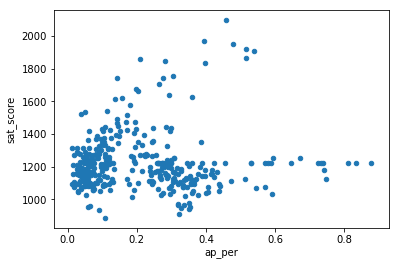

In [45]:
combined.plot.scatter(x="ap_per", y="sat_score")

In [47]:
combined["ap_per"].corr(combined["sat_score"])

0.05717081390766969

There is a weak positive correlation between the percentage of AP test takes and SAT scores, but it is not very strong. 

# Class size and SAT scores

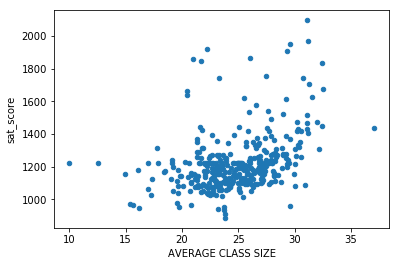

In [49]:
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")

In [50]:
combined["AVERAGE CLASS SIZE"].corr(combined["sat_score"])

0.38101433080955249

There does appear to be a modest positive correlation between average class size and SAT scores. This is counter to what one would think, as larger average class sizes have higher SAT scores. This trend is seen on the scatter plot. This may be due to low class sizes for remedial classes or those with behavioral problems and special needs. 

# Which neighborhoods have the best schools

Look at boroughs, and then by school district. Just comparing the average SAT score and the percentaage of AP test takers. 

In [81]:
metrics = ["boro", "sat_score", "ap_per", 'Number of Exams with scores 3 4 or 5','Total Exams Taken']
boro_sat = combined.groupby("boro").agg(numpy.mean).reset_index()
boro_sat.loc[ : , metrics]

,boro,sat_score,ap_per,Number of Exams with scores 3 4 or 5,Total Exams Taken
0,Bronx,1157.598203,0.189331,135.694086,149.445409
1,Brooklyn,1181.364461,0.217670,164.940094,202.857765
2,Manhattan,1278.331410,0.246578,153.337778,192.661966
3,Queens,1286.753032,0.184006,153.975000,238.014423
4,Staten Island,1382.500000,0.176337,194.435000,355.111538


Manhattan has the schools with the highest rate of AP test takers, but Staten Island has the highest SAT scores on average. Staten Island had on average the highest number of AP tests with a 3,4,5 but they did also take the most exams on average as well. 

In [85]:
metrics = ["school_dist", "sat_score", "ap_per", 'Number of Exams with scores 3 4 or 5','Total Exams Taken']
districts = combined.groupby("school_dist").agg(numpy.mean).reset_index()
districts_metric = districts.loc[ : , metrics]

In [92]:
districts_metric[["sat_score", "ap_per"]].max()

sat_score    1450.500000
ap_per          0.396711
dtype: float64

In [93]:
districts_metric[districts_metric["sat_score"] == 1450.500000]

,school_dist,sat_score,ap_per,Number of Exams with scores 3 4 or 5,Total Exams Taken
21,22,1450.5,0.215706,370.3625,614.509615


The school district with the highest SAT score is district 22, which is in Brooklyn (stretches from Ditmas Park in central Brooklyn to seaside community of Mill Basin on Jamaica Bay). 

In [97]:
districts_metric[districts_metric["ap_per"] >= 0.396711]

,school_dist,sat_score,ap_per,Number of Exams with scores 3 4 or 5,Total Exams Taken
17,18,1118.0,0.396711,153.45,197.038462


The school district with the highest percentage of AP students is district 18, which is in Brooklyn (neighborhoods of Flatbush and Canarsie in southeast Brooklyn).